# Modeling
- In this notebook, we will iterate through many __model types__, __feature subsets__, and __hyperparameter values__. Model __combinations__ will also be explored.
- The goal is to find the model that performs the best on unseen data. We will use target variables from 2007-2022 as training and validation data, then finally test our best models on the current 2023 season.
- We will measure model performance using __Root-mean-squared-error__ and __R-squared__.

## Imports

In [292]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import r2_score, mean_squared_error

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format

sns.set_theme(context='talk', style='whitegrid')

# global random_state
random_state = 9

## Load data

In [293]:
df = pd.read_csv('./train_data/data.csv').drop(['Unnamed: 0'], axis=1)

In [294]:
# drop rows with null target (players in their final season or 2023 players)
df = df.dropna(subset=['target'])

## 2022 season
- The 2022 season rows already have the 2023 target appended to them.
- These rows will strictly be kept as a holdout test set.

In [295]:
# 2022 players with 2023 target (test set)
players_2022 = df[df['year'] == 2022]

# drop these rows from training data
df = df.drop(players_2022.index)

In [296]:
# train set
df.shape, len(set(df.player))

((970, 70), 218)

- 970 QB seasons for training and validation.
- 66 total features + player name, team, year, and target.
- 218 unique QBs.

In [297]:
# test set
players_2022.shape, len(set(players_2022.player))

((48, 70), 48)

- With 2023 target: 48 seasons of 48 unique QBs.

# Results_df, Function to test model performance

In [298]:
# df to store model results
results_df = pd.read_csv('./models/models.csv').drop('Unnamed: 0', axis=1)

In [299]:
def cross_val(estimator, df, feature_subset, feature_subset_str, pca=False, poly=False, results_df=results_df, 
              random_state=random_state):
    '''
    
    
    Scale data using a specific feature subset from the dataframe, incorporating PCA or Polynomial Features if specified.
    Perform 10-fold cross validation,  append RMSE, R^2, and hyperparameters to results_df.
    
    Parameters:
    estimator (sklearn.estimator) - estimator to cross validate
    df (pandas.Dataframe) - dataframe to create X and y from
    feature_subset (list) - features to be used from input dataframe
    feature_subset_str (str) - name of the feature subset to be stored in results_df
    pca (boolean) - if True, transform data using principal component analysis
    poly (boolean) - if True, transform features into polynomial
    
    Returns:
    rmse (float) - average Root-Mean_Squared-Error from cross validation
    r2 (float) - average R^2 from cross validation
    
    
    
    '''

    
    
    # features and target
    X = df[feature_subset]
    y = df.target

    # create pieline
    pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('estimator', estimator)
        ])
    
    # pca retaining 99% variance
    if pca:
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.99)),
            ('estimator', estimator)
        ])
        
    # polynomial features with degree = 2    
    if poly:
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2)),
            ('estimator', estimator)
        ])
    
    # 5-fold cross validation
    results = cross_validate(pipeline, X, y, cv=5, scoring=['neg_root_mean_squared_error', 'r2'])
    
    # get rmse and r-squared
    rmse = results['test_neg_root_mean_squared_error'].mean() * -1
    r2 = results['test_r2'].mean()
    
    # append results to results_df. last 2 columns indicate if 9-game split is used
    results_df.loc[len(results_df.index)] = [rmse, r2, str(estimator), feature_subset_str, pca, poly]
    
    return rmse, r2

# Models
- Below, we create unique feature subsets and test them on 5 different machine learning algorithms.

## Feature subsets
- Different model types perform differently depending on the input features.
- 7 diverse feature sets to address this problem.

In [300]:
# all features
all_feats = df.drop(['player', 'team_name', 'year', 'target'], axis=1).columns.tolist()

# normalized stats in the form of percentages or averages
percent_features = ['pass_accuracy_percent', 'pass_avg_depth_of_target', 'pass_avg_time_to_throw', 'pass_btt_rate', 
                    'pass_drop_rate', 'pass_grades_offense', 'pass_grades_pass', 'pass_pressure_to_sack_rate', 
                    'pass_sack_percent', 'pass_twp_rate', 'pass_ypa', 'rush_grades_run', 'rush_ypa', 'rush_yco_attempt', 
                    'pass_tds_gm', 'pass_yds_gm', 'exp', 'rolling_mean', 'rolling_std']

# features that have > 0.3 correlation with target, also including engineered features
high_corrs = ['player_game_count', 'pass_aimed_passes', 'pass_attempts', 'pass_bats', 'pass_big_time_throws', 
              'pass_completions', 'pass_def_gen_pressures', 'pass_dropbacks', 'pass_drops', 'pass_first_downs', 
              'pass_grades_offense', 'pass_grades_pass', 'pass_hit_as_threw', 'pass_interceptions', 'pass_passing_snaps', 
              'pass_penalties', 'pass_qb_rating', 'pass_sacks', 'pass_thrown_aways', 'pass_touchdowns', 
              'pass_turnover_worthy_plays', 'pass_yards', 'rush_attempts', 'rush_fumbles', 'rush_run_plays', 
              'rush_total_touches', 'rolling_mean', 'pass_tds_gm', 'pass_yds_gm', 'exp', 'rolling_std']

# 3 grades statistics + 4 engineered features
grades_only = ['pass_grades_offense', 'pass_grades_pass', 'rush_grades_run', 'pass_tds_gm', 'pass_yds_gm', 'exp', 
               'rolling_mean', 'rolling_std']

# offensive grade + 4 engineered features
grades_offense = ['pass_grades_offense', 'pass_tds_gm', 'pass_yds_gm', 'exp', 'rolling_mean', 'rolling_std']

# grades_only + total touchdown statistics
tds = grades_only + ['pass_tds_gm', 'pass_yds_gm']

# using domain knowledge to pick features i think will be most meaningful
intuition = ['pass_btt_rate', 'pass_twp_rate', 'pass_accuracy_percent', 'pass_pressure_to_sack_rate', 'rush_grades_run', 
                    'pass_tds_gm', 'pass_yds_gm', 'exp', 'rolling_mean', 'rolling_std']

In [301]:
# dict of name: feature subset
feature_subset_dict = {'all_feats': all_feats, 'percent_features': percent_features, 'high_corrs': high_corrs, 
                       'grades_only': grades_only, 'grades_offense': grades_offense, 'tds': tds, 'intuition': intuition}

### Linear Regression
- Good 'ol linear regression.

In [302]:
lr = LinearRegression()

In [303]:
# normal data
for i, (name, feats) in enumerate(feature_subset_dict.items()):
    cross_val(lr, df=df, feature_subset=feats, feature_subset_str=name)
    
# with pca
for i, (name, feats) in enumerate(feature_subset_dict.items()):
    cross_val(lr, df=df, feature_subset=feats, feature_subset_str=name, pca=True)
    
# with poly
for i, (name, feats) in enumerate(feature_subset_dict.items()):
    cross_val(lr, df=df, feature_subset=feats, feature_subset_str=name, poly=True)
    
# both pca and poly
for i, (name, feats) in enumerate(feature_subset_dict.items()):
    cross_val(lr, df=df, feature_subset=feats, feature_subset_str=name, pca=True, poly=True)

In [304]:
# 3 best LinReg
results_df[results_df['model'].str.contains('Linear')].sort_values('rmse', ascending=True).head(3)

,rmse,r2,model,feats,pca,poly
9,12.37,0.30,LinearRegression(),high_corrs,True,False
2,12.37,0.30,LinearRegression(),high_corrs,False,False
19,12.40,0.30,LinearRegression(),tds,False,True


### KNN
- KNN is known to perform well with small data sets. 
- It is also known to thrive with smaller feature sets.

In [305]:
knn = KNeighborsRegressor()

In [306]:
# normal data
for i, (name, feats) in enumerate(feature_subset_dict.items()):
    cross_val(knn, df=df, feature_subset=feats, feature_subset_str=name)
    
# with pca
for i, (name, feats) in enumerate(feature_subset_dict.items()):
    cross_val(knn, df=df, feature_subset=feats, feature_subset_str=name, pca=True)
    
# with poly
for i, (name, feats) in enumerate(feature_subset_dict.items()):
    cross_val(knn, df=df, feature_subset=feats, feature_subset_str=name, poly=True)
    
# both pca and poly
for i, (name, feats) in enumerate(feature_subset_dict.items()):
    cross_val(knn, df=df, feature_subset=feats, feature_subset_str=name, pca=True, poly=True)

In [307]:
results_df[results_df['model'].str.contains('KN')].sort_values('rmse', ascending=True).head(3)

,rmse,r2,model,feats,pca,poly
37,13.02,0.23,KNeighborsRegressor(),high_corrs,True,False
30,13.10,0.22,KNeighborsRegressor(),high_corrs,False,False
51,13.18,0.21,KNeighborsRegressor(),high_corrs,True,True


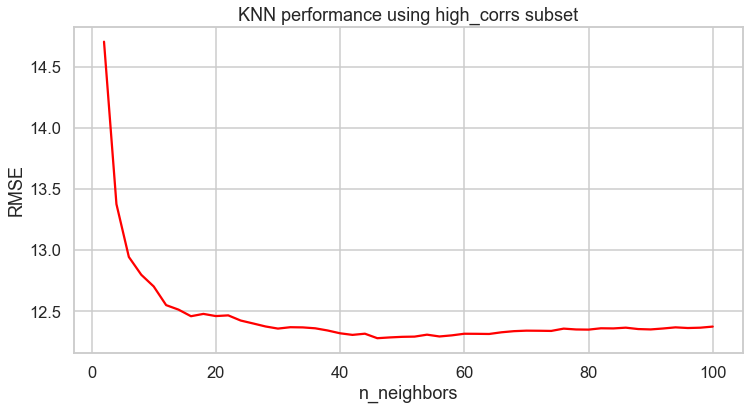

In [308]:
# 2-100 neighbors, increment by 2
k_values = range(2, 101, 2)

# to hold losses
losses = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    
    # use best subset found from above
    rmse, r2 = cross_val(knn, df=df, feature_subset=high_corrs, feature_subset_str='high_corrs')
    
    # append losses
    losses.append(rmse) 
    
# plot results
plt.figure(figsize=(12, 6))
sns.lineplot(x=k_values, y=losses, color='red')

plt.title('KNN performance using high_corrs subset')
plt.ylabel('RMSE')
plt.xlabel('n_neighbors');

In [309]:
# 3 best KNN
results_df[results_df['model'].str.contains('KN')].sort_values('rmse', ascending=True).head(3)

,rmse,r2,model,feats,pca,poly
78,12.28,0.31,KNeighborsRegressor(n_neighbors=46),high_corrs,False,False
79,12.29,0.31,KNeighborsRegressor(n_neighbors=48),high_corrs,False,False
80,12.29,0.31,KNeighborsRegressor(n_neighbors=50),high_corrs,False,False


### Decision Tree
- Decision trees are good at handling many features. This means the "all_feats" set will likely perform well.

In [310]:
dt = DecisionTreeRegressor(random_state=random_state)

In [311]:
for i, (name, feats) in enumerate(feature_subset_dict.items()):
    cross_val(dt, df=df, feature_subset=feats, feature_subset_str=name)

In [312]:
results_df[results_df['model'].str.contains('Decision')].sort_values('rmse', ascending=True).head(3)

,rmse,r2,model,feats,pca,poly
108,17.22,-0.35,DecisionTreeRegressor(random_state=9),high_corrs,False,False
112,17.29,-0.36,DecisionTreeRegressor(random_state=9),intuition,False,False
106,17.32,-0.37,DecisionTreeRegressor(random_state=9),all_feats,False,False


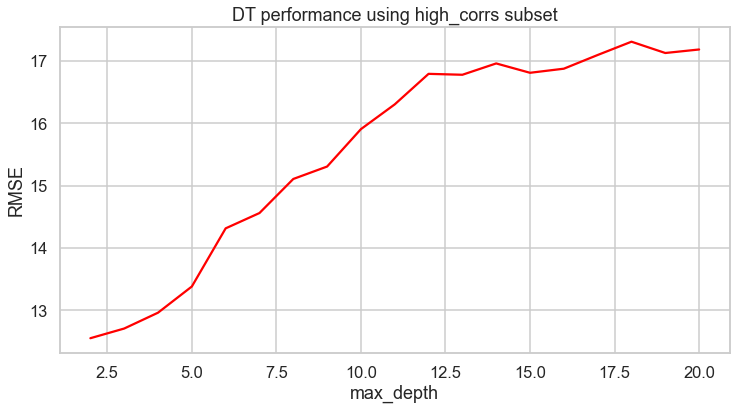

In [313]:
# max_depths from 2-20
d_values = range(2, 21)

# to hold losses
losses = []

for d in d_values:
    dt = DecisionTreeRegressor(random_state=random_state, max_depth=d)
    
    # use best subset found from above
    rmse, r2 = cross_val(dt, df=df, feature_subset=high_corrs, feature_subset_str='high_corrs')
    
    # append losses
    losses.append(rmse) 
    
# plot results
plt.figure(figsize=(12, 6))
sns.lineplot(x=d_values, y=losses, color='red')

plt.title('DT performance using high_corrs subset')
plt.ylabel('RMSE')
plt.xlabel('max_depth');

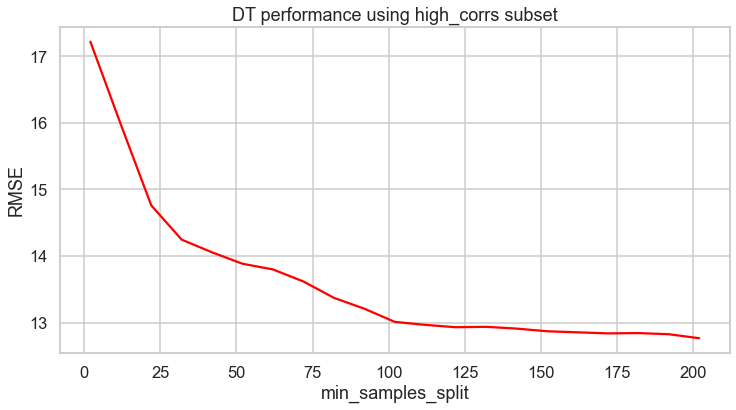

In [314]:
# min_samples_split from 2- 200, increment by 10
s_values = range(2, 203, 10)

# to hold losses
losses = []

for s in s_values:
    dt = DecisionTreeRegressor(random_state=random_state, min_samples_split=s)
    
    # use best subset found from above
    rmse, r2 = cross_val(dt, df=df, feature_subset=high_corrs, feature_subset_str='high_corrs')
    
    # append losses
    losses.append(rmse) 
    
# plot results
plt.figure(figsize=(12, 6))
sns.lineplot(x=s_values, y=losses, color='red')

plt.title('DT performance using high_corrs subset')
plt.ylabel('RMSE')
plt.xlabel('min_samples_split');

In [315]:
# 3 best DTs
results_df[results_df['model'].str.contains('Decision')].sort_values('rmse', ascending=True).head(3)

,rmse,r2,model,feats,pca,poly
113,12.56,0.28,"DecisionTreeRegressor(max_depth=2, random_stat...",high_corrs,False,False
114,12.71,0.27,"DecisionTreeRegressor(max_depth=3, random_stat...",high_corrs,False,False
152,12.76,0.26,"DecisionTreeRegressor(min_samples_split=202, r...",high_corrs,False,False


### Random Forest

In [316]:
rf = RandomForestRegressor(random_state=random_state)

In [317]:
# normal data
for i, (name, feats) in enumerate(feature_subset_dict.items()):
    cross_val(rf, df=df, feature_subset=feats, feature_subset_str=name)

In [318]:
results_df[results_df['model'].str.contains('Random')].sort_values('rmse', ascending=True).head(3)

,rmse,r2,model,feats,pca,poly
153,12.43,0.30,RandomForestRegressor(random_state=9),all_feats,False,False
154,12.44,0.30,RandomForestRegressor(random_state=9),percent_features,False,False
155,12.45,0.30,RandomForestRegressor(random_state=9),high_corrs,False,False


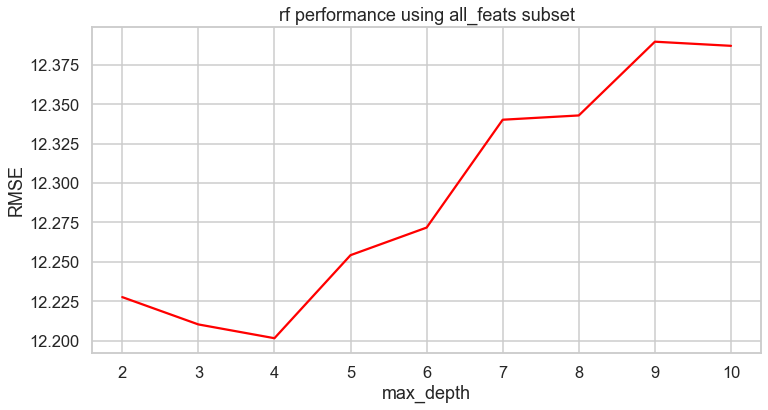

In [319]:
# max_depths from 2-10
d_values = range(2, 11)

# to hold losses
losses = []

for d in d_values:
    rf = RandomForestRegressor(random_state=random_state, max_depth=d)
    
    # use best subset found from above
    rmse, r2 = cross_val(rf, df=df, feature_subset=all_feats, feature_subset_str='all_feats')
    
    # append losses
    losses.append(rmse) 
    
# plot results
plt.figure(figsize=(12, 6))
sns.lineplot(x=d_values, y=losses, color='red')

plt.title('rf performance using all_feats subset')
plt.ylabel('RMSE')
plt.xlabel('max_depth');

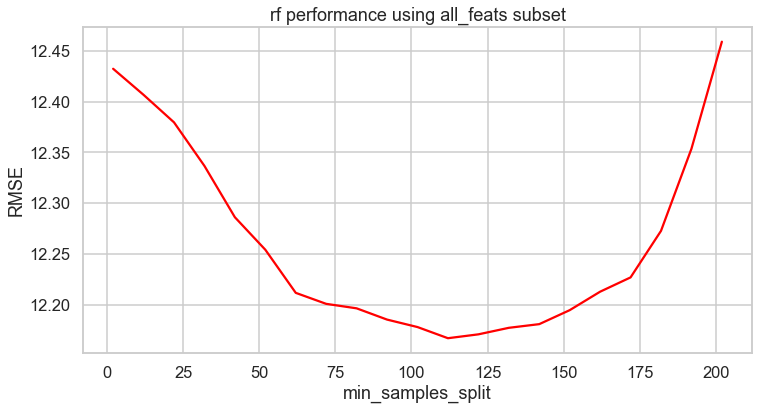

In [320]:
# min_samples_split from 2- 200, increment by 10
s_values = range(2, 203, 10)

# to hold losses
losses = []

for s in s_values:
    rf = RandomForestRegressor(random_state=random_state, min_samples_split=s)
    
    # use best subset found from above
    rmse, r2 = cross_val(rf, df=df, feature_subset=all_feats, feature_subset_str='all_feats')
    
    # append losses
    losses.append(rmse) 
    
# plot results
plt.figure(figsize=(12, 6))
sns.lineplot(x=s_values, y=losses, color='red')

plt.title('rf performance using all_feats subset')
plt.ylabel('RMSE')
plt.xlabel('min_samples_split');

In [321]:
# 3 best RF
results_df[results_df['model'].str.contains('Random')].sort_values('rmse', ascending=True).head(3)

,rmse,r2,model,feats,pca,poly
180,12.17,0.33,"RandomForestRegressor(min_samples_split=112, r...",all_feats,False,False
181,12.17,0.33,"RandomForestRegressor(min_samples_split=122, r...",all_feats,False,False
182,12.18,0.32,"RandomForestRegressor(min_samples_split=132, r...",all_feats,False,False


### XGBoost
- XGBosst is notorious for performing well on a wide array of problems.

In [322]:
xgb = XGBRegressor(n_jobs=-1, random_state=random_state, n_estimators=1000, learning_rate=0.01)

In [323]:
for i, (name, feats) in enumerate(feature_subset_dict.items()):
    cross_val(xgb, df=df, feature_subset=feats, feature_subset_str=name)

In [324]:
# 3 best XGB
results_df[results_df['model'].str.contains('XGB')].sort_values('rmse', ascending=True).head(3)

,rmse,r2,model,feats,pca,poly
190,12.79,0.26,"XGBRegressor(base_score=None, booster=None, co...",all_feats,False,False
191,13.02,0.23,"XGBRegressor(base_score=None, booster=None, co...",percent_features,False,False
192,13.11,0.22,"XGBRegressor(base_score=None, booster=None, co...",high_corrs,False,False


## Combining models
- After trying 5 different models and searching through many hyperparameters, our best validation results came from the RandomForestRegressor with a val RMSE of __12.17__ and a val R^2 of __0.33__. 
- This is quite poor performance, as the target variable has a mean of 64 and a std of 15. This means that on average, our best preds our almost a full standard deviation off of the true value.
- Hoping to milk slightly more performance out of these models by combining these models in different ways.

### VotingRegressor
- Using best model found from each algorithm.

In [325]:
# models that did best with high_corrs subset
lr_best = LinearRegression()
knn_best = KNeighborsRegressor(n_neighbors=46)
dt_best = DecisionTreeRegressor(random_state=random_state, max_depth=2)

# models that did best with all_feats subset
rf_best = RandomForestRegressor(random_state=random_state, min_samples_split=112)
xgb_best = XGBRegressor(random_state=random_state, n_estimators=1000, learning_rate=0.01)

In [326]:
# voting regressor on high_corrs data
vote_1 = VotingRegressor(estimators=[
    ('lr', lr_best), 
    ('knn', knn_best), 
    ('dt', dt_best)])
cross_val(vote_1, df=df, feature_subset=high_corrs, feature_subset_str='high_corrs')

# voting regressor on all_feats data
vote_2 = VotingRegressor(estimators=[
    ('rf', rf_best), 
    ('xgb', xgb_best)])
cross_val(vote_2, df=df, feature_subset=all_feats, feature_subset_str='all_feats')

results_df[results_df['model'].str.contains('Vot')].sort_values('rmse', ascending=True).head()

,rmse,r2,model,feats,pca,poly
197,12.18,0.32,"VotingRegressor(estimators=[('lr', LinearRegre...",high_corrs,False,False
198,12.30,0.31,"VotingRegressor(estimators=[('rf',\n ...",all_feats,False,False


- Results are still not as good as the Random Forest.

### StackingRegressor
- Using best model found from each algorithm.

In [327]:
# stacking regressor on high_corrs data
stack_1 = StackingRegressor(estimators=[
    ('lr', lr_best), 
    ('knn', knn_best), 
    ('dt', dt_best)])
cross_val(stack_1, df=df, feature_subset=high_corrs, feature_subset_str='high_corrs')

# stacking regressor on all_feats data
stack_2 = StackingRegressor(estimators=[
    ('rf', rf_best), 
    ('xgb', xgb_best)])
cross_val(stack_2, df=df, feature_subset=all_feats, feature_subset_str='all_feats')

results_df[results_df['model'].str.contains('Stack')].sort_values('rmse', ascending=True).head()

,rmse,r2,model,feats,pca,poly
200,12.17,0.32,"StackingRegressor(estimators=[('rf',\n ...",all_feats,False,False
199,12.21,0.32,"StackingRegressor(estimators=[('lr', LinearReg...",high_corrs,False,False


- Once again, results are slightly worse than the Random Forest.

In [328]:
# save model results
results_df.to_csv('./models/models.csv')

# 2023 predictions
- After iterating through many different model/feature/hyperparameter combinations, our best model was a __Random Forest with  min_samples_split of 112__.
- This model will be trained on the entire train/val data, and then will predict 2023 offensive grade from the 2022 holdout set.

In [329]:
# best random forest
rf_best = RandomForestRegressor(random_state=random_state, min_samples_split=112)

# features and target
X_train = df[all_feats]
y_train = df.target
X_test = players_2022[all_feats]
y_test = players_2022.target

# create pieline
pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', rf_best)
    ])

# train on entire dataset
pipeline.fit(X_train, y_train)

# predict
preds = pipeline.predict(X_test)

print(f'RMSE: {mean_squared_error(y_test, preds, squared=False)}')
print(f'R^2 : {r2_score(y_test, preds)}')

RMSE: 12.157436114762524
R^2 : 0.397691290884134


- Using the best random forest we achieved an __RMSE of 12.16__. This means that on average, our 2023 predictions are 12.16 points off the true grade of a player. Our __R^2 is 0.4__, meaning that this model explains 40% of the variation in the target variable.

In [330]:
# create a df for our predictions
preds_df = pd.DataFrame(data={'player': players_2022['player'].values, 'team': players_2022['team_name'].values, 
                              'y_true': y_test, 'y_pred': preds, 'error': (preds - y_test)})

In [331]:
# team colors for plotting predictions
nfl_team_colors = {
    'GB': '#203731',   # Green Bay Packers
    'NO': '#D3BC8D',   # New Orleans Saints
    'LA': '#003594',   # Los Angeles Rams
    'DAL': '#041E42',  # Dallas Cowboys
    'NYG': '#0B2265',  # New York Giants
    'LV': '#000000',   # Las Vegas Raiders
    'SEA': '#002244',  # Seattle Seahawks
    'PHI': '#004C54',  # Philadelphia Eagles
    'DET': '#0076B6',  # Detroit Lions
    'SF': '#AA0000',   # San Francisco 49ers
    'CIN': '#FB4F14',  # Cincinnati Bengals
    'BUF': '#00338D',  # Buffalo Bills
    'CHI': '#0B162A',  # Chicago Bears
    'LAC': '#0080C6',  # Los Angeles Chargers
    'PIT': '#FFB612',  # Pittsburgh Steelers
    'MIN': '#4F2683',  # Minnesota Vikings
    'ARZ': '#97233F',  # Arizona Cardinals
    'BLT': '#241773',  # Baltimore Ravens
    'NE': '#002244',   # New England Patriots
    'KC': '#E31837',   # Kansas City Chiefs
    'DEN': '#FB4F14',  # Denver Broncos
    'TEN': '#0C2340',  # Tennessee Titans
    'WAS': '#773141',  # Washington Commanders
    'JAX': '#006778',  # Jacksonville Jaguars
    'MIA': '#008E97',  # Miami Dolphins
    'NYJ': '#125740',  # New York Jets
    'TB': '#D50A0A',   # Tampa Bay Buccaneers
    'CLV': '#311D00',  # Cleveland Browns
    'ATL': '#A71930',  # Atlanta Falcons
    'CAR': '#0085CA',  # Carolina Panthers
}

# map colors to our preds_df
preds_df['color'] = preds_df['team'].map(nfl_team_colors)

In [332]:
# show 2023 predictions for all 48 QBs
preds_df.sort_values('error')[['player', 'y_true', 'y_pred', 'error']].T

,936,566,354,77,177,1262,784,657,1288,1247,666,1117,557,208,63,698,749,695,1097,1057,998,421,548,1170,1304,164,723,1114,502,488,702,415,778,619,615,342,423,144,800,366,802,957,1268,110,71,990,964,25
player,Matthew Stafford,Jared Goff,Dak Prescott,Baker Mayfield,Brock Purdy,Tua Tagovailoa,Lamar Jackson,Jordan Love,Tyrod Taylor,Trevor Lawrence,Josh Allen,Sam Howell,Jameis Winston,C.J. Beathard,Andy Dalton,Justin Fields,Kirk Cousins,Joshua Dobbs,Ryan Tannehill,Russell Wilson,Patrick Mahomes,Deshaun Watson,Jalen Hurts,Taylor Heinicke,Zach Wilson,Brian Hoyer,Kenny Pickett,Sam Darnold,Geno Smith,Gardner Minshew,Justin Herbert,Derek Carr,Kyler Murray,Joe Burrow,Jimmy Garoppolo,Cooper Rush,Desmond Ridder,Brett Rypien,Mac Jones,Daniel Jones,Malik Willis,Mike White,Tyler Huntley,Blaine Gabbert,Bailey Zappe,P.J. Walker,Mitch Trubisky,Aaron Rodgers
y_true,83.70,90.60,87.60,73.30,78.10,87.50,87.50,71.30,66.80,82.70,89.80,67.50,67.70,66.20,81.10,73.60,86.10,66.30,72.00,77.10,87.10,66.90,81.30,65.30,59.90,57.90,66.80,59.80,75.30,56.60,77.80,68.10,65.60,78.00,65.60,53.10,48.90,48.10,59.00,63.00,45.90,46.20,45.20,40.20,41.30,30.80,34.80,39.40
y_pred,61.97,72.23,72.68,59.95,65.90,75.70,75.84,60.18,57.16,73.49,80.73,59.27,59.76,58.36,74.31,66.85,79.54,59.97,65.76,71.09,81.66,61.52,77.64,62.26,56.90,54.99,63.92,58.49,74.60,57.99,79.60,71.37,69.12,81.61,70.24,58.31,55.38,56.39,68.35,73.04,58.70,59.49,60.60,56.92,60.91,55.95,62.58,78.00
error,-21.73,-18.37,-14.92,-13.35,-12.20,-11.80,-11.66,-11.12,-9.64,-9.21,-9.07,-8.23,-7.94,-7.84,-6.79,-6.75,-6.56,-6.33,-6.24,-6.01,-5.44,-5.38,-3.66,-3.04,-3.00,-2.91,-2.88,-1.31,-0.70,1.39,1.80,3.27,3.52,3.61,4.64,5.21,6.48,8.29,9.35,10.04,12.80,13.29,15.40,16.72,19.61,25.15,27.78,38.60


In [333]:
# percent of preds within 10 pts
percent = (preds_df.error.abs() < 10).sum() / len(preds_df)

print(f'{percent*100:.1f}% of our model\'s predictions are within 10pts of the true value.')

64.6% of our model's predictions are within 10pts of the true value.


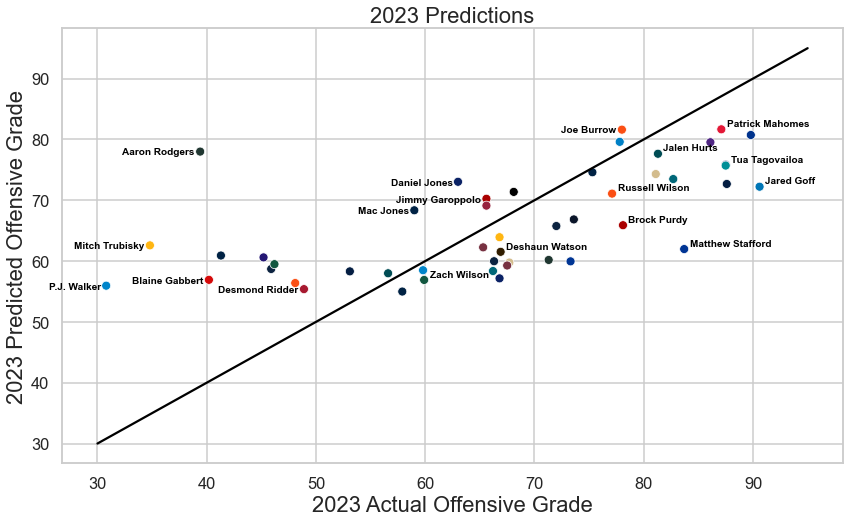

In [334]:
# visualize 2023 predictions
plt.figure(figsize=(14, 8))

# lists for annotating player names
over_preds = ['Aaron Rodgers', 'Jimmy Garoppolo', 'Joe Burrow', 'P.J. Walker', 'Mitch Trubisky', 'Daniel Jones', 'Mac Jones', 
              'Desmond Ridder', 'Blaine Gabbert']
under_preds = ['Zach Wilson', 'Patrick Mahomes', 'Matthew Stafford', 'Jared Goff', 'Jalen Hurts', 'Tua Tagovailoa', 
               'Russell Wilson', 'Brock Purdy', 'Deshaun Watson']

# title, labels
plt.title('2023 Predictions', fontsize=22)
plt.xlabel('2023 Actual Offensive Grade', fontsize=22)
plt.ylabel('2023 Predicted Offensive Grade', fontsize=22)

# team colors
color_palette = {color: color for color in preds_df['color'].unique()}

# plot players as points
sns.scatterplot(data=preds_df, x='y_true', y='y_pred', hue='color', palette=color_palette, legend=False)

# plot line to show perfect predictions
sns.lineplot(x=range(30,96), y=range(30,96), color='black')

# annotating each point with the player's name
for index, row in preds_df.iterrows():
    if row['player'] in over_preds:
        plt.text(row['y_true']-0.5, row['y_pred']-0.5, row['player'], horizontalalignment='right', size='small', color='black', 
             weight='semibold', fontsize=10)
    elif row['player'] in under_preds:
        plt.text(row['y_true']+0.5, row['y_pred']+0.5, row['player'], horizontalalignment='left', size='small', color='black', 
             weight='semibold', fontsize=10)
             
plt.savefig('./images/preds');

- Each point represents a single player in 2023. The distance from the black line is how far off our prediction was. Ideally, a perfect model would only have dots on the line. Dots above the line are cases in which our model overpredicted the player's performance, and dots below the line are under-predictions. Some of the worst predictions are labeled above.
- You can see that the worst prediction, by far, is Aaron Rodgers, with an error of 38.6. It should be noted that he was injured on the 4th play of the 2023 season with a torn achilles, so this point is definitely an outlier. If we drop this point, our RMSE goes from a __12.16 to a 10.92__, and R^2 leaps from a __0.4 to a 0.49__. This is shown below.

In [335]:
# all 48 QBs
print(f'Normal RMSE: {mean_squared_error(y_test, preds, squared=False)}')
print(f'Normal R^2 : {r2_score(y_test, preds)}\n')

# without aaron rodgers
print(f'Dropping Aaron Rodgers - RMSE: {mean_squared_error(y_test[1:], preds[1:], squared=False)}')
print(f'Dropping Aaron Rodgers - R^2 : {r2_score(y_test[1:], preds[1:])}')

Normal RMSE: 12.157436114762524
Normal R^2 : 0.397691290884134

Dropping Aaron Rodgers - RMSE: 10.920073785075424
Dropping Aaron Rodgers - R^2 : 0.492223269173908


In [336]:
# percent of preds within 10 pts
percent = (preds_df[1:].error.abs() < 10).sum() / (len(preds_df) - 1)

print(f'Excluding Aaron Rodgers, {percent*100:.1f}% of our model\'s predictions are within 10pts of the true value.')

Excluding Aaron Rodgers, 66.0% of our model's predictions are within 10pts of the true value.


# Conclusion
- using an optimized random forest regressor, we were able to predict 2023 QB offensive grade with an RMSE of 12.16 and an R^2 of 0.40.
- It should also be noted that these accuracy metrics are only taken from the first 10 weeks of the 2023 season. This repository will be updated once the 2023 season is complete; I will show the error and R^2 of the best model on the full 2023 season. Then, I can make predictions on the 2024 NFL season!